In [1]:
"""
The general method for the ARIMA implementation comes from:

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
"""

'\nThe general method for the ARIMA implementation comes from:\n\nhttps://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7\nhttps://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/\n'

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima

#Imported to ignore warnings from ARIMA
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
def read_data(pathname, indicatorcode):
    df = pd.read_excel(pathname)
    
    df2 = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df2 = df2.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    df3 = df2.swapaxes('index', 'columns')
    
    return df3

In [5]:
"""
Method for this block of code is refactored from both:

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
"""

def stationarityTest(data):
    
    #Find out if the data is stationary or not
    #Using Rolling Statistics (Rolling Mean and Rolling Std)
    rolling_mean = data.rolling(window=10).mean()
    rolling_std = data.rolling(window=10).std()
    
    plt.plot(data, color='blue', label='original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('RM vs RSTD vs ORI')
    
    #Augmented Dickey-Fuller Test
    result = adfuller(data.dropna())
    print('ADF Statistic: {}'.format(result[0]))
    #print(f'p-value: {result[1]}')
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [6]:
"""
Method 1 & 2 refactored from:

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

Method 3 refactored from:

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
"""

def make_stationary(data):
    
#There are multiple methods to make a time series stationary

#Method 1 - Subtracting the rolling mean
    rolling_mean = data.rolling(window=10).mean()
    data_minus = data - rolling_mean
    data_minus_dropped = data_minus.dropna(inplace=True)

#Method 2 - Exponential Decay
    exp_decay = data.ewm(halflife=10).mean()
    data_minus_ewm = data - exp_decay
    data_minus_ewm_dropped = data_minus_ewm.dropna(inplace=True)

#Method 3 - Differencing the series

#1st Order Differencing
    data_first_od = data.diff()
    data_first_od_dropped = data_first_od.dropna(inplace=True)
    
    return data_minus, data_minus_ewm, data_first_od

In [7]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)

In [8]:
data = read_data('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
                     'SL.UEM.TOTL.FE.ZS')

In [9]:
data = data.dropna()

In [10]:
data_minus, data_minus_ewm, data_first_od = make_stationary(data)

ADF Statistic: -1.4538774558003453
p-value: 0.556192
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004


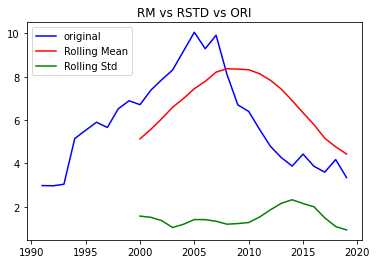

In [11]:
stationarityTest(data)

ADF Statistic: -1.7730437572141693
p-value: 0.393924
Critical Values:
	1%: -4.068853732362312
	5%: -3.1271488757396453
	10%: -2.7017297633136095


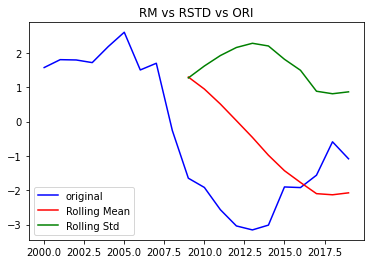

In [12]:
stationarityTest(data_minus)

ADF Statistic: -0.4774035601273539
p-value: 0.896351
Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224


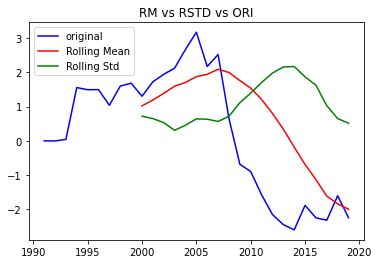

In [13]:
stationarityTest(data_minus_ewm)

ADF Statistic: -3.8989828434958826
p-value: 0.002042
Critical Values:
	1%: -3.6996079738860943
	5%: -2.9764303469999494
	10%: -2.627601001371742


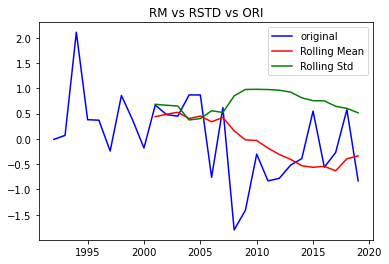

In [14]:
stationarityTest(data_first_od)

In [ ]:
"""
Learned how to read PACF and ACF plots from 

https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8
"""

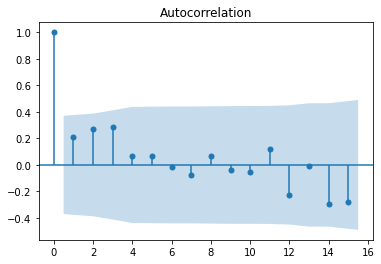

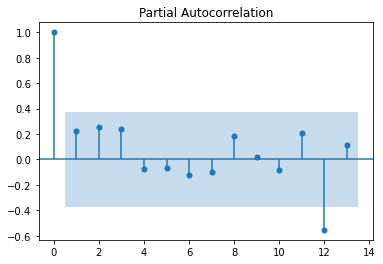

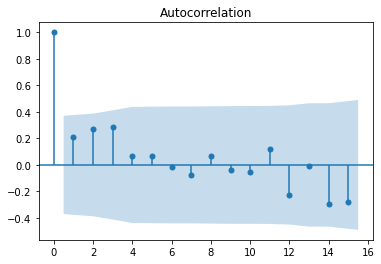

In [15]:
#Find AR order(p), differencing order(d), MA(q)

#Find AR order(p) using a PACF, only considering the 
plot_pacf(data_first_od.dropna(), lags=13)

#Find MA order (q) using acf plot
plot_acf(data_first_od.dropna())

In [16]:
test_size = len(data) - int(len(data) * 0.8)

train = data[:-test_size]
test = data[-test_size:]

In [17]:
print(train.shape, test.shape)

(23, 1) (6, 1)


In [38]:
model = ARIMA(train, order=(12,1,1))
model = model.fit()
predict = model.predict(start=len(train), end=len(train)+len(test)-1)

RMSE:  0.6209089805986507
MAPE:  16.701594238275366
MAE:  0.5433038725274121
Scatter Index:  15.982213508992421
MDA:  0.56
Mean of actual:  3.884999910990397


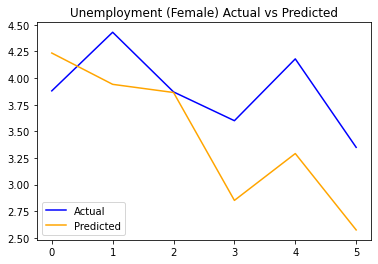

In [41]:
df_actual = pd.DataFrame(test.values)
df_predict = pd.DataFrame(predict.values)
plt.plot(df_actual, color='blue', label='Actual')
plt.plot(df_predict, color='orange', label='Predicted')
plt.legend(loc='best')
plt.title('Unemployment (Female) Actual vs Predicted')
performance_metrics(test.values, predict.values)

In [20]:
performance_metrics(test.values, predict.values)

RMSE:  0.6209089805986507
MAPE:  16.701594238275366
MAE:  0.5433038725274121
Scatter Index:  15.982213508992421
MDA:  0.56
Mean of actual:  3.884999910990397


In [21]:
"""
Idea for using pmdarima attributed to the video on youtube:

https://www.youtube.com/watch?v=8FCDpFhd1zk&ab_channel=NachiketaHebbar
"""

stepwise_fit = auto_arima(data, trace=True, suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=129.868, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=76.026, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=105.266, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=191.179, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=76.345, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=76.933, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=76.146, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.217 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -35.013
Date:                Wed, 13 Apr 2022   AIC                             76.026
Time:                        03:20:01   BIC                             80.128
Sample:                             0   HQIC                            77.311
                                 - 29                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2875      0.456      0.631      0.528      -0.606       1.181
ar.L1          0.9367      0.068     13.753      0.000       0.803       1.070
sigma2         0.6092      0.217      2.807      0.005       0.184       1.035
===================================================================================
Ljung-Box (L1) (Q):                   1.58   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.21   Prob(JB):                         0.84
Heteroskedasticity (H):               0.54   Skew:                             0.23
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""